# Caso Práctico: Isolation Forest

## Conjunto de datos: Detección de transacciones bancarias fraudulentas

### Descripción
The datasets contains transactions made by credit cards in September 2013 by european cardholders. 
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

### Descarga de los ficheros de datos
https://www.kaggle.com/mlg-ulb/creditcardfraud#creditcard.csv

### Referencias adicionales sobre el conjunto de datos
_The dataset has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection.
More details on current and past projects on related topics are available on https://www.researchgate.net/project/Fraud-detection-5 and the page of the DefeatFraud project._

## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.gridspec as gridspec
from collections import Counter
from sklearn import metrics
import numpy as np
from matplotlib.colors import LogNorm
from sklearn.metrics import f1_score

## 1. Lectura del conjunto de datos

In [2]:
df = pd.read_csv("datasets/creditcard.csv")

## 2. Visualización del conjunto de datos

In [3]:
df.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


In [4]:
print("Número de características:", len(df.columns))
print("Longitud del conjunto de datos:", len(df))

Número de características: 31
Longitud del conjunto de datos: 284807


In [5]:
# 492 transacciones fraudulentas, 284315 transacciones legitimas
# El conjunto de datos se encuntra desequilabrado
df["Class"].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

In [6]:
# Visualizamos los tipos de cada uno de los atributos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [7]:
# Comprobamos si alguna columna tiene valores nulos
df.isna().any()

Time      False
V1        False
V2        False
V3        False
V4        False
V5        False
V6        False
V7        False
V8        False
V9        False
V10       False
V11       False
V12       False
V13       False
V14       False
V15       False
V16       False
V17       False
V18       False
V19       False
V20       False
V21       False
V22       False
V23       False
V24       False
V25       False
V26       False
V27       False
V28       False
Amount    False
Class     False
dtype: bool

In [8]:
#df.describe()

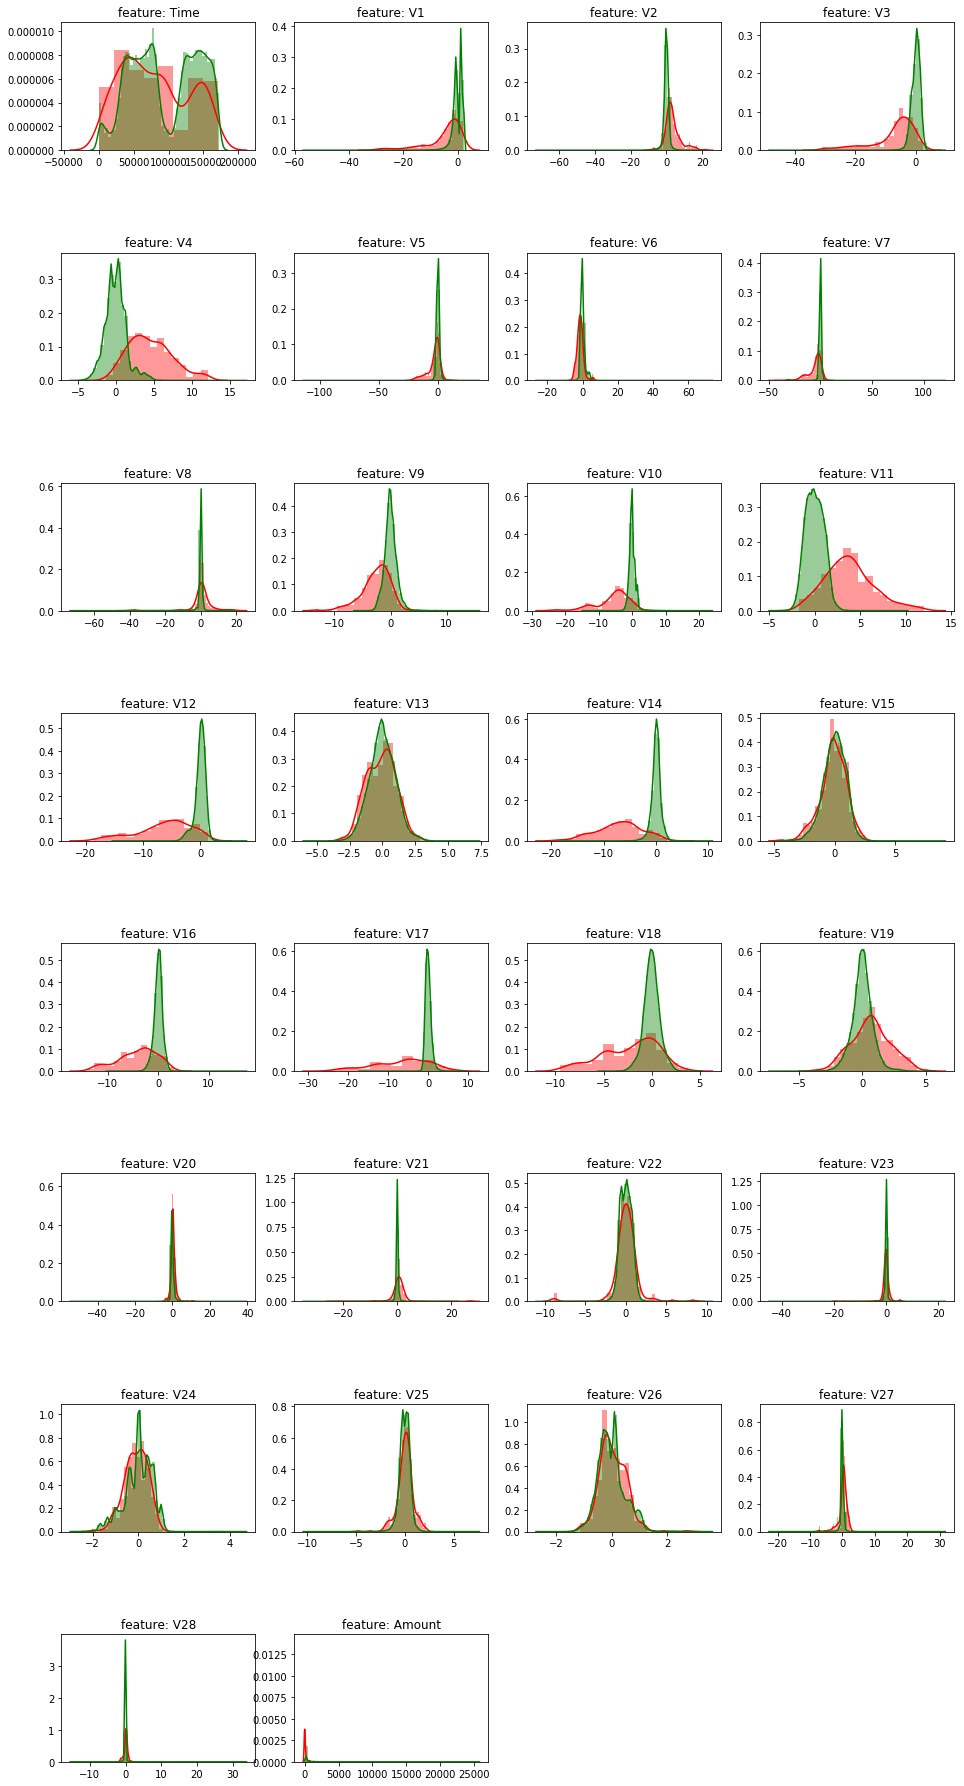

In [9]:
# Representamos gráficamente las características
features = df.drop("Class", axis=1)

plt.figure(figsize=(16,32))
gs = gridspec.GridSpec(8, 4)
gs.update(hspace=0.8)

for i, f in enumerate(features):
    ax = plt.subplot(gs[i])
    sns.distplot(df[f][df["Class"] == 1], color='r')
    sns.distplot(df[f][df["Class"] == 0], color='g')
    ax.set_xlabel('')
    ax.set_title('feature: ' + str(f))

plt.show()

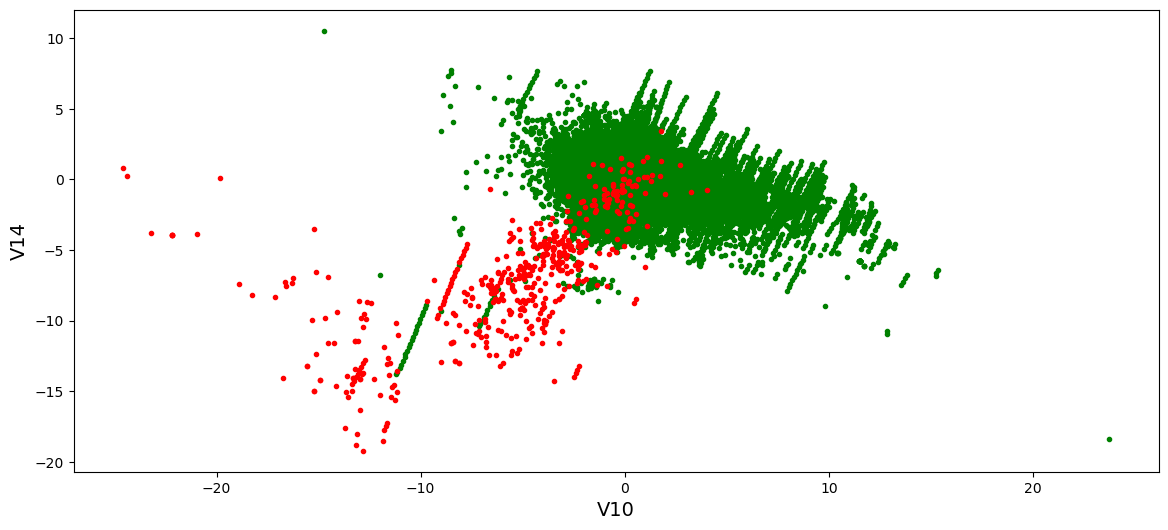

In [9]:
# Representación gráfica de dos características
plt.figure(figsize=(14, 6))
plt.scatter(df["V10"][df['Class'] == 0], df["V14"][df['Class'] == 0], c="g", marker=".")
plt.scatter(df["V10"][df['Class'] == 1], df["V14"][df['Class'] == 1],c="r", marker=".")
plt.xlabel("V10", fontsize=14)
plt.ylabel("V14", fontsize=14)
plt.show()

C:\Users\Uusario\AppData\Local\Temp\ipykernel_35408\3135322028.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df["V14"][df['Class'] == 1], color='r')
C:\Users\Uusario\AppData\Local\Temp\ipykernel_35408\3135322028.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df["V14"][df['Class'] == 0

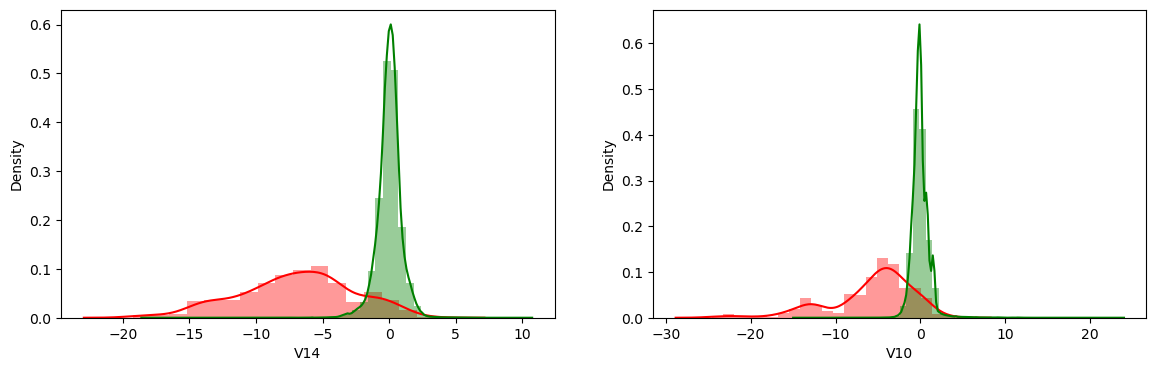

In [10]:
plt.figure(figsize=(14,4))
gs = gridspec.GridSpec(1, 2)
# Representación de la característica 1
ax = plt.subplot(gs[0])
sns.distplot(df["V14"][df['Class'] == 1], color='r')
sns.distplot(df["V14"][df['Class'] == 0], color='g')
# Representación de la cracterística 2
ax = plt.subplot(gs[1])
sns.distplot(df["V10"][df['Class'] == 1], color='r')
sns.distplot(df["V10"][df['Class'] == 0], color='g')
plt.show()

## 3. Preparación del conjunto de datos

Para este tipo de algoritmos es importante que todos los datos se encuentren en un rango similar, por lo tanto, podemos aplicar una función de escalado o normalización. Otra opción, es eliminar las características que no se encuentran en un rango similar siempre y cuando no sean muy influyentes para la predicción.

In [11]:
df_prep = df.drop(["Time", "Amount"], axis=1)

## 4. Isolation Forest con un conjunto de datos de dos dimensiones

Antes de comenzar con la detección de anomalías mediante Isoltaion Forest para todos los atributos del conjunto de datos, se realiza una prueba para dos atributos con el objetivo de comprender como construye el límite de decisión.

In [12]:
X = df_prep.drop("Class", axis=1)
y = df_prep["Class"].copy()

In [13]:
X_reduced = X[["V10", "V14"]].copy()

**Entrenamiento del algoritmo con un conjunto de datos reducido**

In [32]:
from sklearn.ensemble import IsolationForest

ift_clf = IsolationForest(contamination=0.01, max_samples=300)
ift_clf.fit(X_reduced)

IsolationForest(contamination=0.01, max_samples=300)

**Representación del límite de decisión**

C:\Users\Uusario\anaconda3\envs\ML_ENERO_2025\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


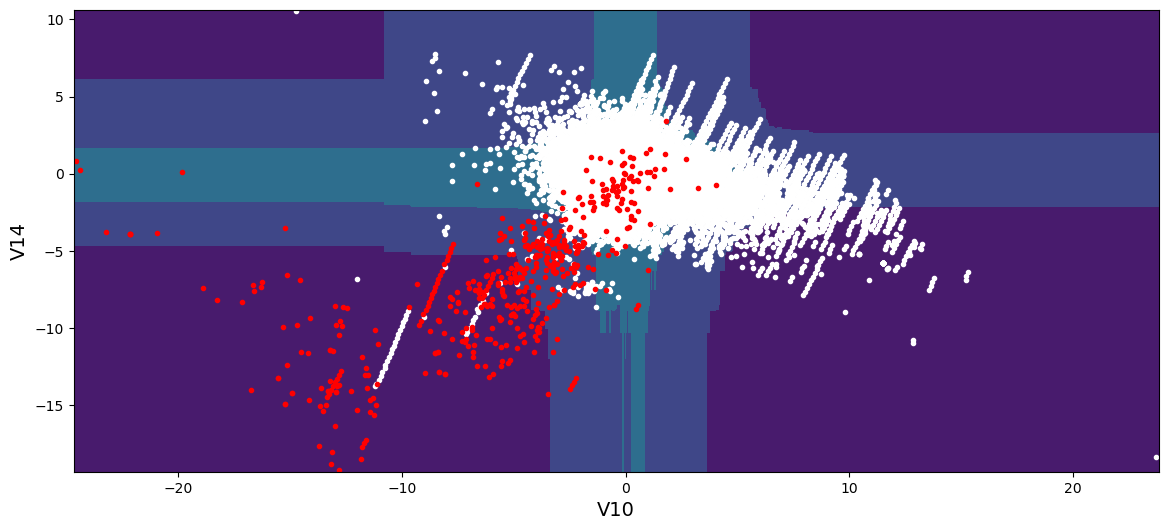

In [33]:
def plot_isolation_forest(X, y, resolution=1000):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    
    Z = ift_clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z)

    plt.plot(X[:, 0][y==0], X[:, 1][y==0], 'w.')
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], 'r.')
    
plt.figure(figsize=(14, 6))
plot_isolation_forest(X_reduced.values, y)
plt.xlabel("V10", fontsize=14)
plt.ylabel("V14", fontsize=14)
plt.show()

**Representación de las anomalías identificadas**

In [34]:
# Identificación de anomalías
anomalies = ift_clf.predict(X_reduced)

C:\Users\Uusario\anaconda3\envs\ML_ENERO_2025\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


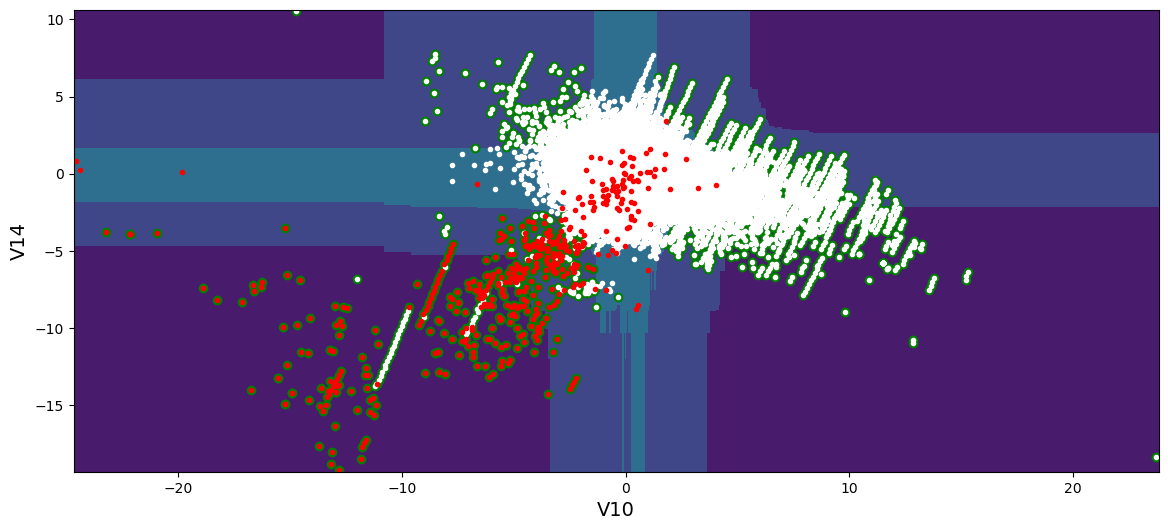

In [35]:
# Representación gráfica de las anomalías
plt.figure(figsize=(14, 6))
plt.plot(X_reduced["V10"][anomalies == -1], X_reduced["V14"][anomalies == -1], 'go', markersize=6)
plot_isolation_forest(X_reduced.values, y)
plt.xlabel("V10", fontsize=14)
plt.ylabel("V14", fontsize=14)
plt.show()

**Predicción con el conjunto de datos reducido**

In [36]:
print("Total de anomalías identificadas:", len(y[anomalies==-1]))

Total de anomalías identificadas: 2849


In [37]:
# Verdaderos y falsos positivos de casos fraudulentos en el total de anomalías
y[anomalies==-1].value_counts()

Class
0    2455
1     394
Name: count, dtype: int64

## 5. Isolation Forest con un conjunto de datos multidimensional

In [38]:
# Entrenamiento del modelo
ift_clf = IsolationForest(max_samples=300, contamination=0.01)
ift_clf.fit(X)

IsolationForest(contamination=0.01, max_samples=300)

In [40]:
# Identificación de anomalías
anomalies = ift_clf.predict(X)

In [41]:
print("Total de anomalías identificadas:", len(y[anomalies==-1]))

Total de anomalías identificadas: 2849


In [42]:
# Verdaderos y falsos positivos de casos fraudulentos
y[anomalies==-1].value_counts()

Class
0    2557
1     292
Name: count, dtype: int64

## 6. Búsqueda del mejor parámetro contaminación

Para utilizar de manera sencilla las técnicas estándar de búsqueda de hiperparámteros de sklearn, el estimador debe devolver un valor entre 0 y 1, sin embargo, la predicción de IsolationForest se encuentra comprendida entre -1 (ejemplo anómalo) y 1 (ejemplo normal). Construimos un estimador personalizado para que devuelva este resultado.

In [26]:
# Creamos nuestro propio estimador para que la salida del algoritmo este comprendida entre 0 y 1
from sklearn.base import BaseEstimator

class IsolationForestCustom(BaseEstimator):
    def __init__(self, max_samples=100, contamination=0.1):
        self.contamination = contamination
        self.max_samples = max_samples
        self._ift_clf = None
        
    def fit(self, X, y=None):
        self._ift_clf = IsolationForest(max_samples=self.max_samples, 
                                        contamination=self.contamination)
        self._ift_clf.fit(X) 
        return self
    
    def predict(self, X, y=None):
        preds = self._ift_clf.predict(X)
        preds[preds==1] = 0
        preds[preds==-1] = 1
        return preds
    
    def get_params(self, deep=True):
        return {"contamination": self.contamination,
               "max_samples": self.max_samples}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

In [27]:
from sklearn.model_selection import GridSearchCV

param_grid = {'max_samples': [100, 200, 300], 'contamination': [0.001, 0.01, 0.1]}

ift_clf = IsolationForestCustom()

# train across 5 folds, that's a total of 6*2=12 rounds of training 
grid_search = GridSearchCV(ift_clf, param_grid, cv=2,
                           scoring='f1', return_train_score=True)

grid_search.fit(X_reduced, y)

GridSearchCV(cv=2, estimator=IsolationForestCustom(),
             param_grid={'contamination': [0.001, 0.01, 0.1],
                         'max_samples': [100, 200, 300]},
             return_train_score=True, scoring='f1')

In [28]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.0 {'contamination': 0.001, 'max_samples': 100}
0.0 {'contamination': 0.001, 'max_samples': 200}
0.1934897771551158 {'contamination': 0.001, 'max_samples': 300}
0.2462347273950894 {'contamination': 0.01, 'max_samples': 100}
0.2313748574371804 {'contamination': 0.01, 'max_samples': 200}
0.24402759014524844 {'contamination': 0.01, 'max_samples': 300}
0.03259752249973885 {'contamination': 0.1, 'max_samples': 100}
0.03178057590462933 {'contamination': 0.1, 'max_samples': 200}
0.030163638333854277 {'contamination': 0.1, 'max_samples': 300}


In [31]:
grid_search.best_score_

0.2462347273950894